# DSCI 6003 5.3 Lecture

### By the end of this lecture, you will:
1. Will be able to describe the standard "loss" functions of boosting
2. Be more familiar with standard tuning practices
3. Be more familiar with standard model construction

## Tuning and model selection in general

When it comes to tuning any estimator you should be looking to to apply your knowledge of the meaning of the parameters as well as the algorithm of the method in order to make intelligent choices about the tuning process.

Some "data scientists" you meet will lean on vast experiential knowledge of a single model or class of models. From this, they will garner some idea of about where to start, purely from their intuition about the way data interacts with the classifier in general. 

### When to Tune

The best time to tune a model is after you know something about its performance with the data. This means tuning usually takes place after initial studies and cross-validation on an initial test/train set of data.

Normally tuning is done to optimize performance in anticipation of using the model in an online or enterprise sense. The model needs to be as unbiased and robust to variance as possible, as we do not know what is coming down the pipe in terms of noise in these situations. 

Sometimes we tune as a last ditch effort to see if a favorite model can be made to perform better at all. This is common in the case of linear models. We might believe beyond a shadow of doubt that a linear model (or linear regression) is the "real" description of the underlying processes, or perhaps (in the case of SVMs), there is some attribute of the system that can only realistically be overcome that way (i.e. tremendously imbalanced classes). In this case, it behooves us to look to see if a model can be made more predictive through tuning. 

Lastly, sometimes tuning is used to describe underlying system behavior. The first example you have seen of this is the squid plot. The paths of the coefficients describe something about their relationship to each other and their significance to predictivity, particularly in the case of lasso and elastic net regressions. Many models can be used in this orthogonal way, as descriptors but not necessarily predictors of the data.

# Tuning Tools

In general we use tuning tools by using them to output some kind of graphical output describing changes in hyperparameters and then look for patterns that suggest an optimum has been achieved. These are usally obvious.


### Grid Search


#### Exhaustive
Grid search is a standard method of optimization, available in many different machine learning environments and packages capable of doing it. There are two kinds of Grid Search, exhaustive and random. Despite the intimidating name, exhaustive grid search is nothing more than a series of `for` loops, each rastering over a dictionary of possible hyperparameter values. The best performance of any of the searched parameters is kept and the chosen hyperparameters are returned:

    results = {}
    parameter_vals = {'p1':[a_1,a_2...a_K], 'p2':[b_1, b_2, ... b_M], ... , 'pN':[zz_1, zz_2, ..., zz_N]}
    
    parameter_sets = generate_parameter_grid by exhaustive combinations
    for set in parameter_sets
        test accuracy of model(set)
    results[set] = accuracy   
    return argmax(results)
    
 
Although scikits has a method for this, it is easy to code up a basic grid search with homemade boilerplate if you wish to generate the parameter combinations on your own. 


#### Random 

A random search for parameter values uses a generating function (typically a selected distribution, i.e. rbf/beta/gamma with user-input parameters) to produce candidate value sets for the hyperparameters. This has two main benefits over an exhaustive search:

1. A budget can be chosen independent of the number of parameters and possible values. Thus the user only has one parameter to handle.
2. Adding parameters that do not influence the performance does not decrease efficiency, contrary to a standard grid search in that manual selections of a specifed parameter may result in very little influence to the tuning.

However a random grid search is not always perfect. Let us discuss the below code:


In [1]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from - 
# what methods might we consider that would improve these estimates
# 
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

# use a full grid over all parameters. 
# The grid search will generate parameter sets for each and every one of these
# 
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

RandomizedSearchCV took 2.29 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.925 (std: 0.005)
Parameters: {'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 7, 'criterion': 'gini', 'max_features': 7, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.917 (std: 0.000)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 6, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.915 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 3, 'max_depth': None}

GridSearchCV took 20.27 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.936 (std: 0.004)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 10, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.93

## QUIZ: 

Here we see that the exhaustive grid search seems to outperform the random variable search. Why?

We need to make a train_test split on the grid search

## Information Criterion Metrics (Model selection: typically regressions)

We have already discussed the use of entropy to estimate the amount of useful information present in a specific distribution of data (specifically the information_gain criterion). A great deal of research has gone into the quantification of useful information present in a distribution. Likewise, much research has gone into quantifying the amount of useful information captured by a single model. 

In order to use these metrics, a complete closed description of the "loss" function has to be available and implemented. Scikit only has one native implementation of automated IC model selection, however, the technique is quite common and well used in research.


### AIC and AIC corrected (AICc)

AIC is founded in information theory. It supposes that the data is generated by some unknown process (distribution free) f. We consider two candidate models to represent f: g1 and g2. If we knew f, then we could find the information lost from using g1 to represent f by calculating the degree to which the two distributions (f and g1) match using information theory; similarly, the information lost from using g2 to represent f can be found similarly. We then choose the candidate model that minimizes the loss of information .

$$ AIC = 2k - 2\ ln{(L)} $$

Where L is the final "loss" (cost) function value for the model's optimized set of parameters. For finite sample sizes, we must correct for the effect of the limits of sampling.

$$ AICc = AIC + \dfrac{2k(k+1)}{(n-k-1)} $$

([from wikipedia](https://en.wikipedia.org/wiki/Akaike_information_criterion))
To apply AIC in practice, we start with a set of candidate models, and then find the models' corresponding AIC values. There will almost always be information lost due to using a candidate model to represent the "true" model (i.e. the process that generates the data). We wish to select, from among the candidate models, the model that minimizes the information loss. We cannot choose with certainty, but we can minimize the estimated information loss.

Suppose that there are M candidate models. Denote the AIC values of those models by $AIC_{1}, AIC_{2}, AIC_{3}, \cdots, AIC_{M}$. Let $AIC_{min}$ be the minimum of those values. Then $P_{i}(AIC) = exp^{{\frac{AIC_{min} − AIC_{i}}{2}}}$ can be interpreted as the relative probability that the ith model minimizes the (estimated) information loss

## BIC

BIC can be derived from AIC, although it comes from a slightly different theoretical origin than AIC. It suffers from sample bias just as AIC (not AICc) does. 

The BIC generally penalizes free parameters more strongly than the Akaike information criterion, though it depends on the size of n and relative magnitude of n and k.

It is important to keep in mind that the BIC can be used to compare estimated models only when the numerical values of the dependent variable are identical for all estimates being compared.

BIC is given as:

$$ BIC = -2 ln{(L)} + k\ ln{(n)} $$



# QUIZ: 
How do we go about implementing AIC/BIC for logistic regression??

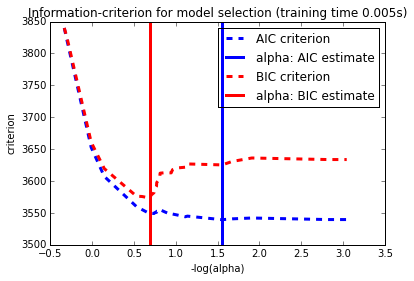

In [24]:
%matplotlib inline
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

X /= np.sqrt(np.sum(X ** 2, axis=0))

##############################################################################
### LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_[:-1]), criterion_[:-1], '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

## OOB Errors (for forests)

Recall that the OOB error describes the loss of accuracy a given tree in a random forest experiences when it is tested on a set of data points, none of which are included in its random sample. Decreasing OOB error suggests that more of the true signal is being captured by the forest. Decreasing OOB score is almost always determined by increasing the numbers of trees in the forest, leading to the famous OOB error rate plot:


Automatically created module for IPython interactive environment


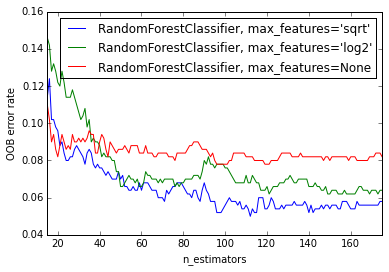

In [26]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier( max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Calibration of Classifiers (honorable mention)


When performing classification one often wants to predict not only the class label, but also the associated probability of each estimate - intuitively this leads to an estimate of how *confident* the classifier is in the prediction. In scikit, this measurement is provided per prediction using the .predict_proba() method for those classifiers which have it implemented (classifiers).

The degree to which we can trust the estimate is illustrated in the calibration plot, as demonstrated below. The plot illustrates predicted vs. actual fraction of positives. Deviations from the straight line indicate errors in calibration.

The calibration performance is evaluated with Brier score, reported in the legend (the smaller the better). One can observe here that logistic regression is well calibrated while raw Gaussian naive Bayes performs very badly. This is because of the redundant features which violate the assumption of feature-independence and result in an overly confident classifier, which is indicated by the typical transposed-sigmoid curve.


Automatically created module for IPython interactive environment
Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



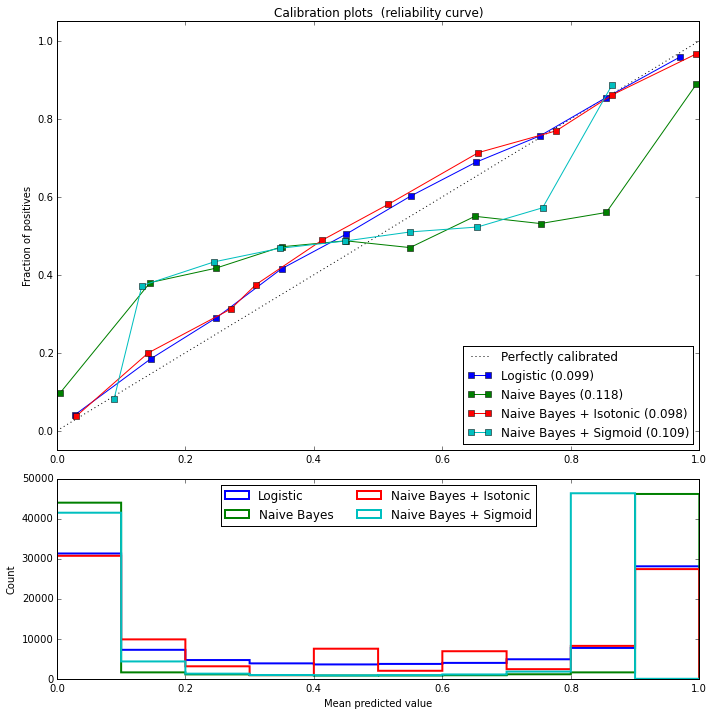

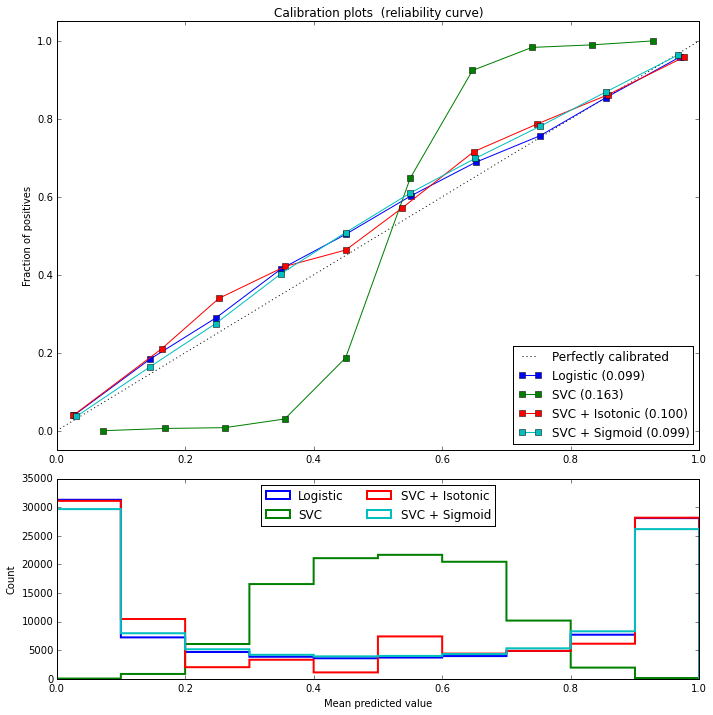

In [2]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration cuve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration cuve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)

plt.show()